In [24]:
from cv_dataset import CVDataset
from training import ensemble_evaluate, train
from unet import UnetDensenet
from utils import CreateBaseTransforms, CreateEnsembleTransforms

import matplotlib.pyplot as plt
import numpy as np
import torchvision

import json

import torch

from monai.apps import (
    CrossValidation
)

from monai.data import (
    DataLoader,
    Dataset, 
    partition_dataset,
)

In [2]:
dataset_path = '/home/marcello/Repositories/DICOM-Project-Pytorch/data/dataset1/dataset1.json'

with open(dataset_path, 'r') as file:
    dataset = json.load(file)

image_paths = [item['image'] for item in dataset['data']]
labels = [item['label'] for item in dataset['data']]

data = list(zip(image_paths, labels))

data_list, test_data = partition_dataset(
    data, ratios=[0.85, 0.15], shuffle=True, seed=42
)

In [3]:
train_val_images = [{"image": img, "label": label} for img, label in data_list]
test_images = [{"image": img, "label": label} for img, label in test_data]

In [4]:
num = 5
folds = list(range(num))

cvdataset = CrossValidation(
    dataset_cls=CVDataset,
    data=train_val_images,
    nfolds=num,
    seed=12345,
    transform=CreateBaseTransforms(),
)

train_dataset = [cvdataset.get_dataset(folds=folds[0:i] + folds[(i + 1) :]) for i in folds]

val_dataset = [cvdataset.get_dataset(folds=i, transform=CreateBaseTransforms()) for i in range(num)]

test_dataset  = Dataset(
    data=test_images, 
    transform=CreateBaseTransforms())

Loading dataset: 100%|██████████| 38/38 [00:00<00:00, 888.40it/s]


In [5]:
train_loaders = [DataLoader(train_dataset[i], batch_size=1, shuffle=True, num_workers=4, pin_memory=False) for i in folds]
val_loaders = [DataLoader(val_dataset[i], batch_size=1, num_workers=4, pin_memory=False) for i in folds]
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=4)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UnetDensenet((224, 224, 1)).to(device)

decoder_filters_in [1024, 256, 128, 64, 32] decoder_filters (256, 128, 64, 32, 16)
upsample_blocks[0]
in: 1024
out: 256

skip_in 1024
upsample_blocks[1]
in: 256
out: 128

skip_in 512
upsample_blocks[2]
in: 128
out: 64

skip_in 256
upsample_blocks[3]
in: 64
out: 32

skip_in 64
upsample_blocks[4]
in: 32
out: 16

skip_in 0


In [7]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])


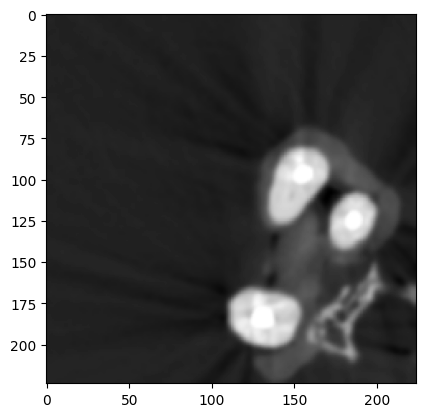

In [8]:
images = 0
imgs = []

for i in train_loaders[0]:
    if images == 4:
        break
    
    images += 1
    print(i['image'].shape)
    imgs.append(i['image'])

npimg = torch.squeeze(imgs[0], dim=1).squeeze(0).numpy()
plt.imshow(npimg,cmap='gray')
plt.show()

In [28]:
models = [train(25, train_loaders[i], val_loaders[i], model, device) for i in range(num)]

for i in range(num):
    print(f'---------------Training for fold {i}---------------')
    models.append(train(25, train_loaders[i], val_loaders[i], model, device))

2024-09-30 21:02:58,687 - INFO - Epoch: 1/25, Iter: 1/153 -- train_loss: 1.5849 
2024-09-30 21:02:58,750 - INFO - Epoch: 1/25, Iter: 2/153 -- train_loss: 1.5858 
2024-09-30 21:02:58,814 - INFO - Epoch: 1/25, Iter: 3/153 -- train_loss: 1.5792 
2024-09-30 21:02:58,879 - INFO - Epoch: 1/25, Iter: 4/153 -- train_loss: 1.5896 
2024-09-30 21:02:58,935 - INFO - Epoch: 1/25, Iter: 5/153 -- train_loss: 1.5866 
2024-09-30 21:02:58,992 - INFO - Epoch: 1/25, Iter: 6/153 -- train_loss: 1.5899 
2024-09-30 21:02:59,050 - INFO - Epoch: 1/25, Iter: 7/153 -- train_loss: 1.5764 
2024-09-30 21:02:59,111 - INFO - Epoch: 1/25, Iter: 8/153 -- train_loss: 1.5834 
2024-09-30 21:02:59,169 - INFO - Epoch: 1/25, Iter: 9/153 -- train_loss: 1.5897 
2024-09-30 21:02:59,228 - INFO - Epoch: 1/25, Iter: 10/153 -- train_loss: 1.5863 
2024-09-30 21:02:59,285 - INFO - Epoch: 1/25, Iter: 11/153 -- train_loss: 1.5828 
2024-09-30 21:02:59,344 - INFO - Epoch: 1/25, Iter: 12/153 -- train_loss: 1.5858 
2024-09-30 21:02:59,411 -

In [ ]:
mean_post_transforms = CreateEnsembleTransforms(len(models))

ensemble_evaluate(mean_post_transforms, models, test_loader, device)